# Solar Challenge Week 1 - Benin Dataset Analysis

## Dataset Description

* This dataset contains solar radiation and meteorological data collected in Malanville, Benin. It includes measurements such as Global Horizontal Irradiance (GHI), Direct Normal Irradiance (DNI), Diffuse Horizontal Irradiance (DHI), air temperature, relative humidity, wind speed, and others. The data spans from [start date] to [end date] (adjust as appropriate).

* The goal is to analyze the solar radiation patterns, clean the data, perform exploratory data analysis, and build a predictive model for GHI.


### Importing Libraries

Here, we import the main Python libraries we’ll use for data analysis, visualization, and modeling.  
These include tools for working with data, making plots, checking statistics, and building a basic prediction model.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

### Loading the Dataset

We load the Benin solar dataset from a CSV file and parse the 'Timestamp' column as dates.  
The first few rows of the data are displayed to get an initial look at the dataset.

In [3]:
file_path = '../data/benin-malanville.csv'  # adjust extension if needed
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
df.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


### Summary Statistics and Missing Values Report

We start by generating summary statistics for all numeric columns to understand the distribution and range of the data.
Next, we check for missing values in each column and calculate the percentage of missing data.
Finally, we list the columns that have more than 5% missing values to identify areas that may require cleaning or imputation.


In [4]:
summary_stats = df.describe()
print("Summary statistics:\n", summary_stats)


missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_report = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
})

print("\nMissing values report:\n", missing_report)

cols_over_5pct_missing = missing_report[missing_report['missing_percent'] > 5].index.tolist()
print("\nColumns with more than 5% missing values:", cols_over_5pct_missing)


Summary statistics:
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-02-07 12:00:30.000000512     240.559452     167.187516   
min              2021-08-09 00:01:00     -12.900000      -7.800000   
25%              2021-11-08 06:00:45      -2.000000      -0.500000   
50%              2022-02-07 12:00:30       1.800000      -0.100000   
75%              2022-05-09 18:00:15     483.400000     314.200000   
max              2022-08-09 00:00:00    1413.000000     952.300000   
std                              NaN     331.131327     261.710501   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      115.358961     236.589496     228.883576      28.179683   
min       -12.600000       0.000000       0.000000      11.000000   
25%        -2.100000       0.000000       0.000000      24.200000   
50%

### Outlier Detection and Basic Cleaning

We focus on key columns related to solar irradiance and wind speed to detect outliers using Z-scores.
Rows with any Z-score greater than 3 are considered outliers and removed from the dataset.
After removing outliers, missing values in these columns are imputed using the median to maintain data integrity.
The cleaned dataset's new shape is printed to confirm the reduction in data size.


In [10]:
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z = np.abs((df[cols_to_check] - df[cols_to_check].mean()) / df[cols_to_check].std())
outliers = (z > 3).any(axis=1)
print(outliers.sum())
df_clean = df[~outliers].copy()
for col in cols_to_check:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
print(df_clean.shape)



7740
(517860, 19)


### Further Data Cleaning and Validation

- Converted 'Timestamp' column to datetime format, dropping any rows with invalid timestamps.
- Filtered the data to keep only rows where GHI, DNI, and DHI values are non-negative, ensuring realistic solar radiation measurements.
- Filled missing values in the 'Comments' column with empty strings.
- Reset the DataFrame index for consistency after row removals.
- Printed the updated shape of the cleaned dataset.

In [11]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], errors='coerce')
df_clean = df_clean.dropna(subset=['Timestamp'])
df_clean = df_clean[df_clean['GHI'] >= 0]
df_clean = df_clean[df_clean['DNI'] >= 0]
df_clean = df_clean[df_clean['DHI'] >= 0]
df_clean['Comments'] = df_clean['Comments'].fillna('')
df_clean.reset_index(drop=True, inplace=True)
print(df_clean.shape)


(241245, 19)


### Data Types and Categorical Columns Identification

- Displayed the data types of all columns in the original DataFrame.
- Identified and listed categorical columns based on their data types (object or category).

In [12]:
print(df.dtypes)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
dtype: object
Categorical columns: []


### Distribution of Key Numerical Variables

- Created histograms for key numerical columns to visualize their distributions.
- This helps to understand the spread, skewness, and potential anomalies in variables like solar irradiance, temperature, humidity, wind speed, and precipitation.

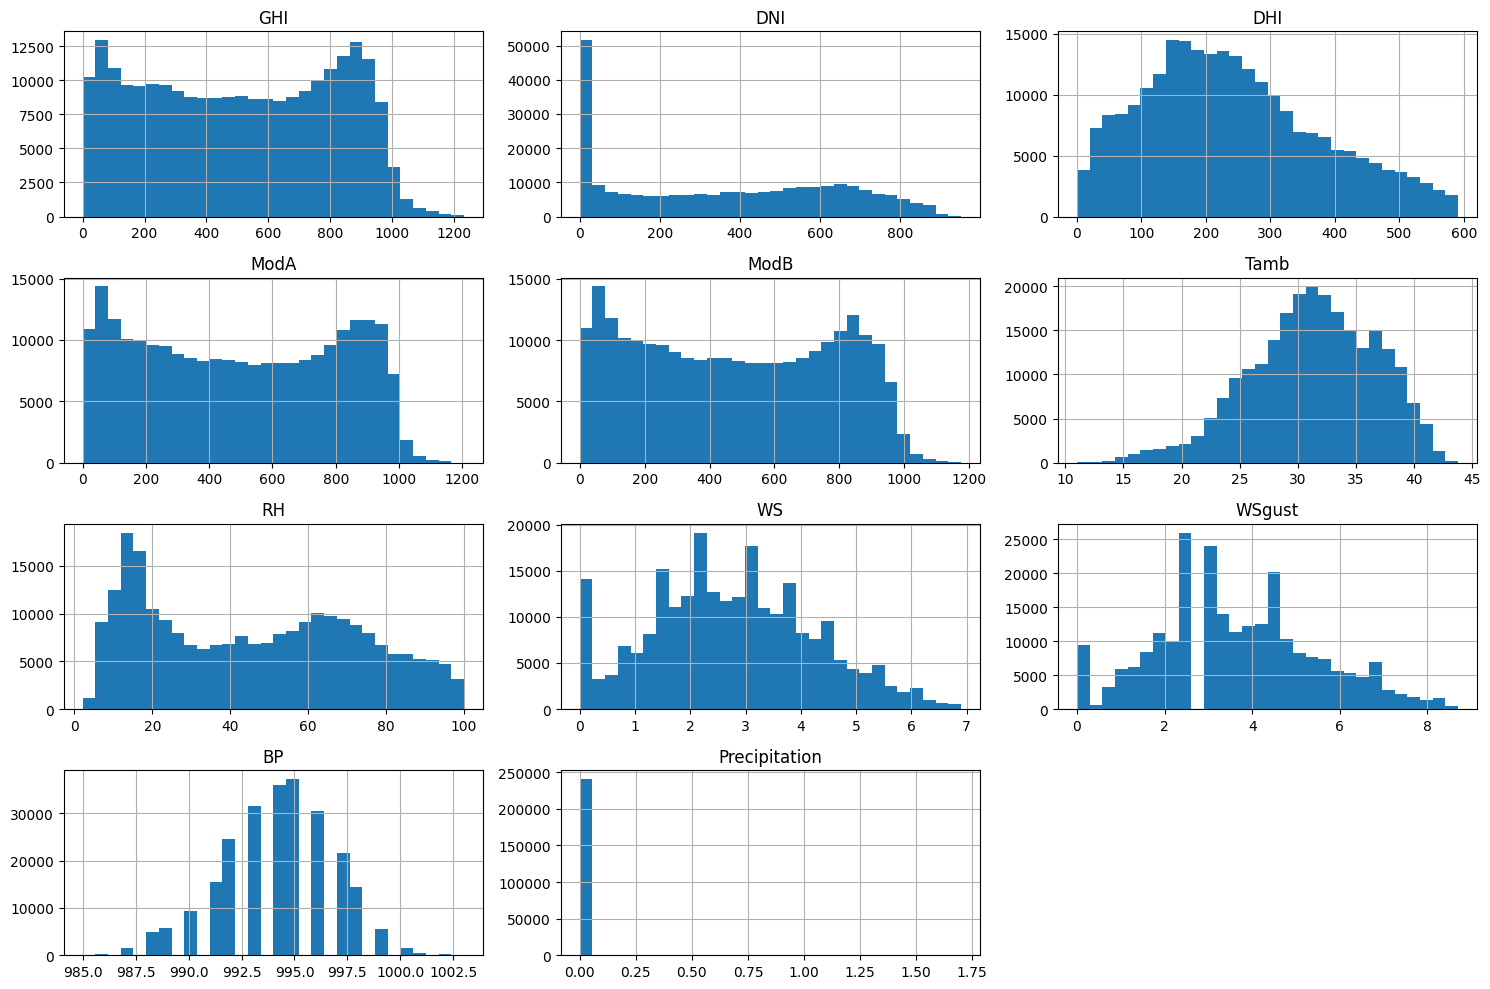

In [13]:
num_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'BP', 'Precipitation']
df_clean[num_cols].hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()


### Global Horizontal Irradiance (GHI) Over Time

- Plotted GHI values against the Timestamp to observe how solar irradiance varies over the recorded period.
- This time series plot reveals daily and seasonal patterns in solar radiation.

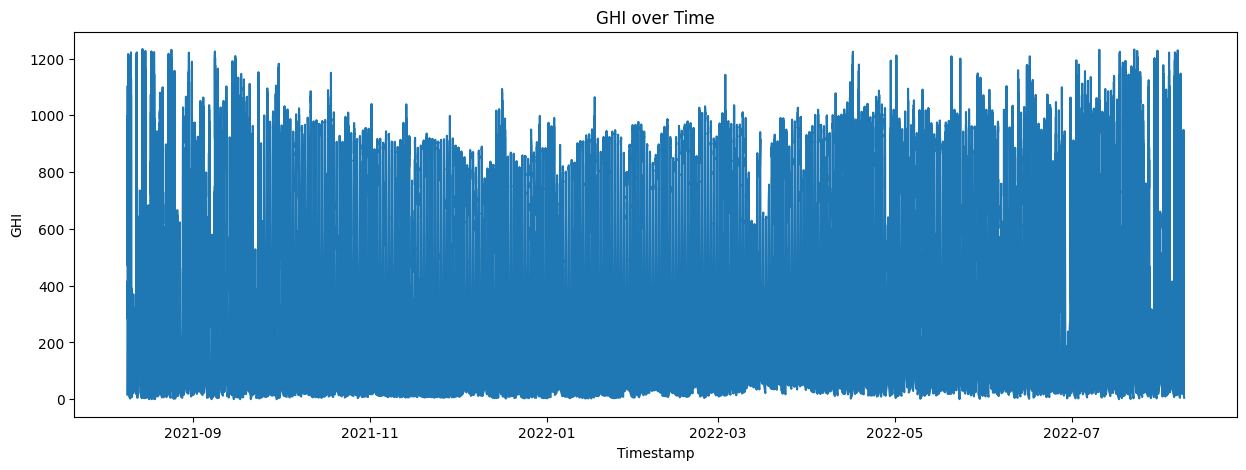

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df_clean['Timestamp'], df_clean['GHI'])
plt.title('GHI over Time')
plt.xlabel('Timestamp')
plt.ylabel('GHI')
plt.show()


### Correlation Heatmap of Numerical Variables

- Visualized the pairwise correlations between key numeric variables including solar irradiance metrics, temperature, humidity, wind speed, pressure, and precipitation.
- The heatmap helps identify strong relationships that could influence solar energy production or environmental conditions.

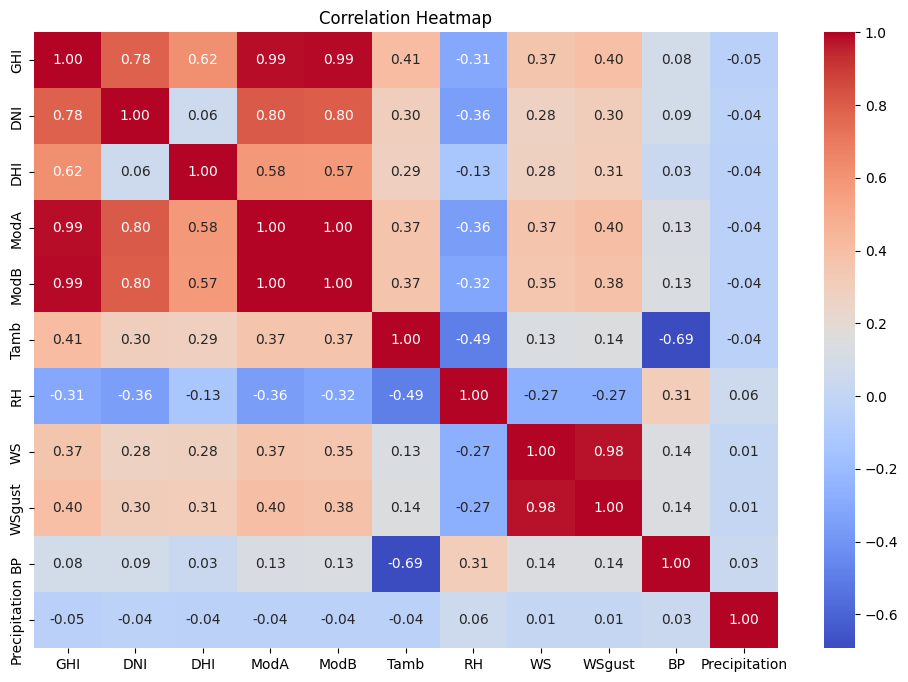

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df_clean[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


### Summary Statistics and Correlation Matrix

- The summary statistics provide an overview of the distribution, central tendency, and spread of key variables related to solar radiation, temperature, humidity, wind, precipitation, and barometric pressure.
- The correlation matrix shows the pairwise relationships between these variables, highlighting how strongly each variable is related to the others. This insight helps in understanding dependencies within the data and guides further analysis.

In [16]:
cols_analysis = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'Precipitation', 'BP']

summary_stats = df_clean[cols_analysis].describe()
correlations = df_clean[cols_analysis].corr()

print(summary_stats)
print('\nCorrelation Matrix:\n', correlations)

                 GHI            DNI            DHI           ModA  \
count  241245.000000  241245.000000  241245.000000  241245.000000   
mean      508.390773     358.814015     241.520069     496.912489   
std       304.156812     280.159803     136.278285     307.484052   
min         0.000000       0.000000       0.000000       0.000000   
25%       235.200000      61.000000     139.700000     214.700000   
50%       510.600000     359.300000     225.200000     491.800000   
75%       785.900000     607.500000     328.500000     782.400000   
max      1233.000000     952.300000     591.400000    1205.100000   

                ModB           Tamb             RH             WS  \
count  241245.000000  241245.000000  241245.000000  241245.000000   
mean      481.148781      31.251281      45.732184       2.755223   
std       298.511121       5.468802      26.961388       1.486475   
min         0.000000      11.000000       2.100000       0.000000   
25%       207.800000      27.7000

### Distribution of Solar Radiation Components

The histograms below show the distribution of the three main solar radiation components:
- **GHI (Global Horizontal Irradiance)**: Total solar radiation received per unit area on a horizontal surface.
- **DNI (Direct Normal Irradiance)**: Solar radiation received directly from the sun on a surface perpendicular to the sun’s rays.
- **DHI (Diffuse Horizontal Irradiance)**: Solar radiation received from the sky (excluding the sun’s direct rays).

These distributions help identify the spread and skewness of the data for each component.


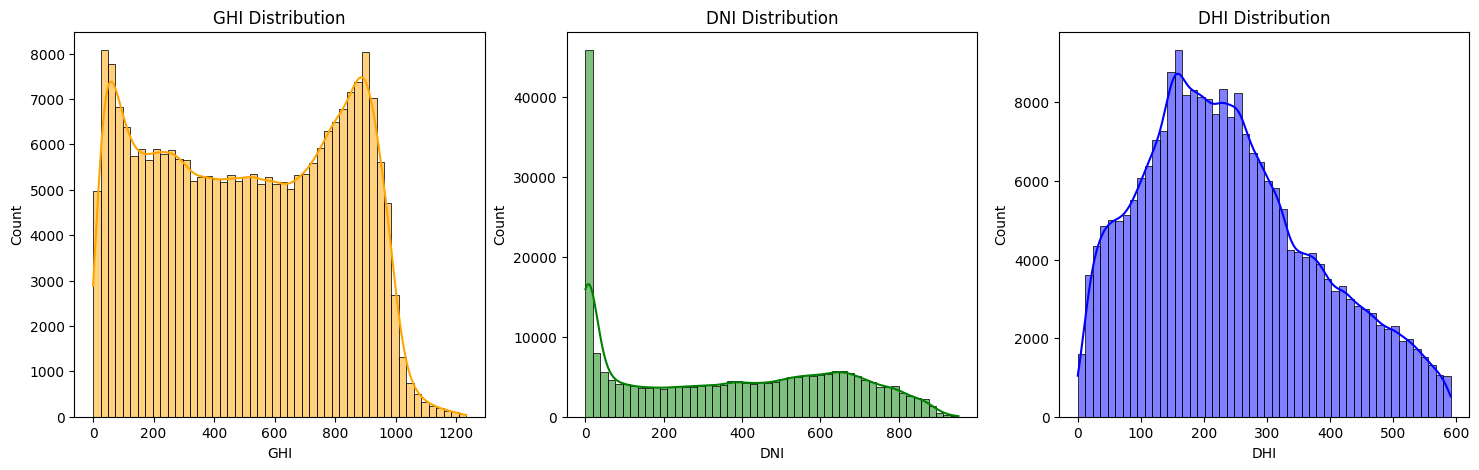

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_clean['GHI'], bins=50, kde=True, ax=axs[0], color='orange')
axs[0].set_title('GHI Distribution')
sns.histplot(df_clean['DNI'], bins=50, kde=True, ax=axs[1], color='green')
axs[1].set_title('DNI Distribution')
sns.histplot(df_clean['DHI'], bins=50, kde=True, ax=axs[2], color='blue')
axs[2].set_title('DHI Distribution')
plt.show()


### Daily and Monthly Average GHI

- We resample the data to compute the daily and monthly average Global Horizontal Irradiance (GHI). 
- The two plots below show how the average GHI varies over time at daily and monthly scales, helping us observe trends and seasonal patterns.


C:\Users\HP\AppData\Local\Temp\ipykernel_11812\3164789356.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_clean.resample('M', on='Timestamp')[cols_to_use].mean()


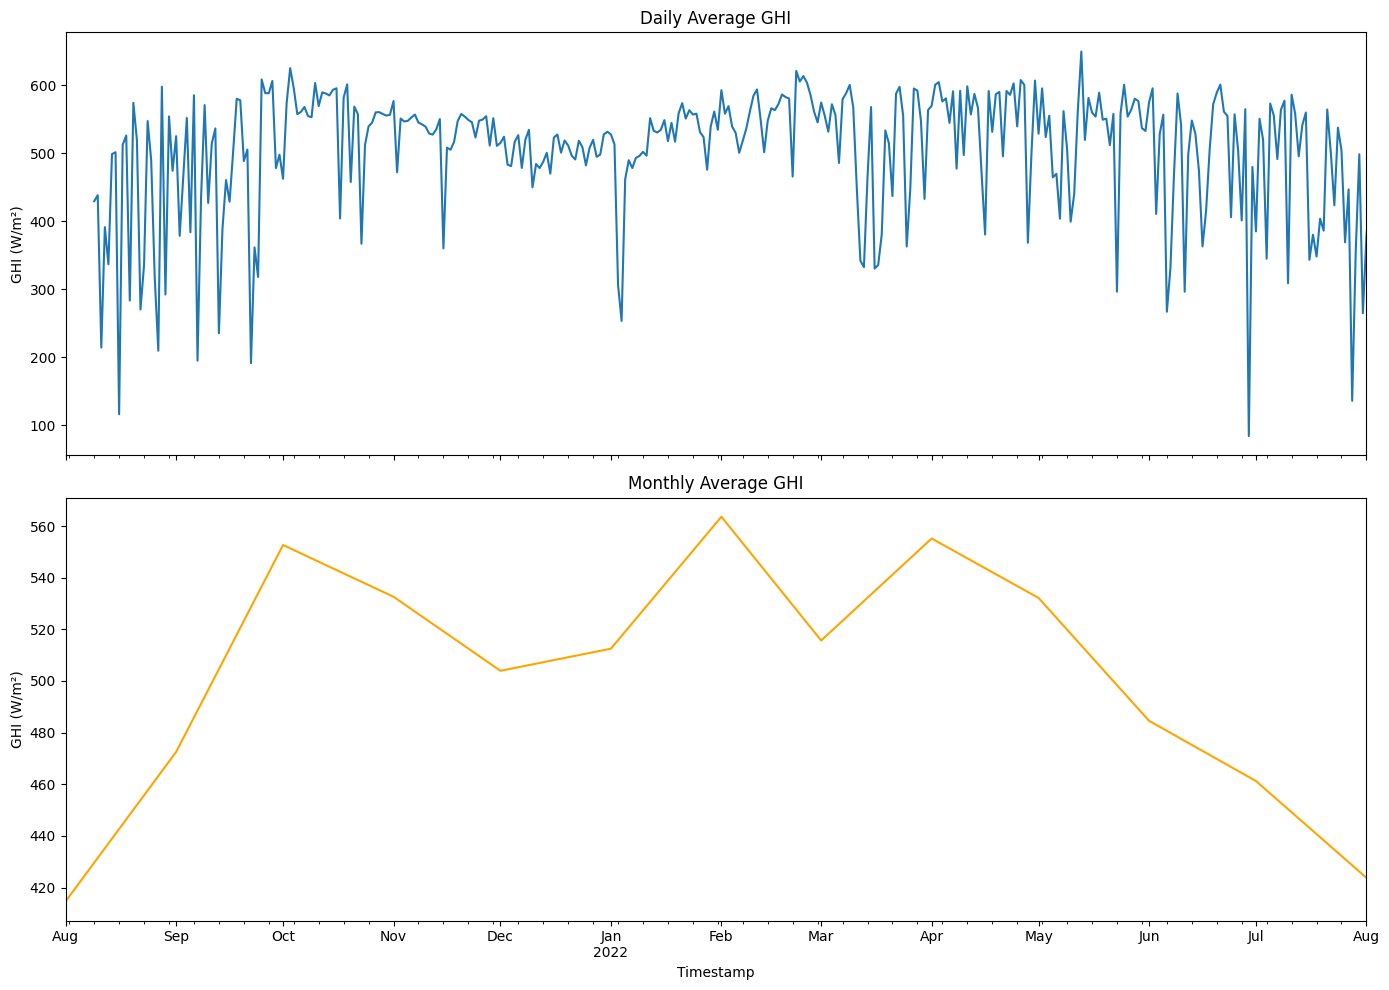

In [20]:
cols_to_use = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'Precipitation', 'BP']

df_daily = df_clean.resample('D', on='Timestamp')[cols_to_use].mean()
df_monthly = df_clean.resample('M', on='Timestamp')[cols_to_use].mean()

fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

df_daily['GHI'].plot(ax=axes[0], title='Daily Average GHI')
axes[0].set_ylabel('GHI (W/m²)')

df_monthly['GHI'].plot(ax=axes[1], title='Monthly Average GHI', color='orange')
axes[1].set_ylabel('GHI (W/m²)')

plt.tight_layout()
plt.show()


### Monthly Average Solar Radiation and Temperature

This plot shows the monthly average values of GHI, DNI, DHI, and ambient temperature (Tamb). It helps us compare the seasonal variations of solar radiation components alongside temperature.


C:\Users\HP\AppData\Local\Temp\ipykernel_11812\2124271639.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df_clean.resample('M', on='Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()


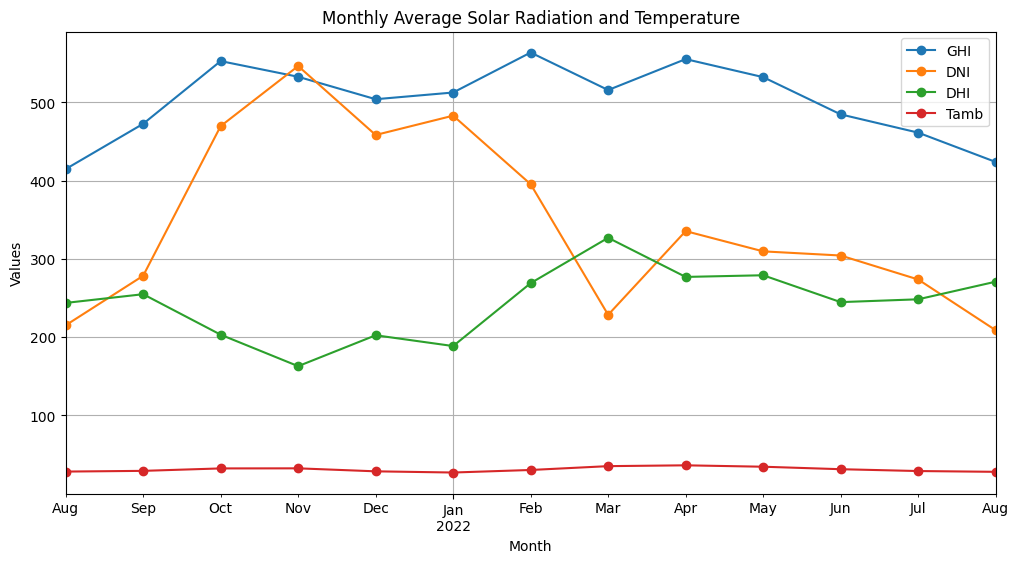

In [21]:
monthly_means = df_clean.resample('M', on='Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_means.plot(figsize=(12,6), marker='o', title='Monthly Average Solar Radiation and Temperature')
plt.ylabel('Values')
plt.xlabel('Month')
plt.grid(True)
plt.show()


### Feature Engineering

We create new time-based features from the `Timestamp` column to help capture temporal patterns in the data. These features include Hour, Day, Month, Weekday, and a binary indicator for weekends. The 'Comments' column is dropped as it is not needed for analysis.


In [23]:
df_features = df_clean.copy()

df_features['Hour'] = df_features['Timestamp'].dt.hour
df_features['Day'] = df_features['Timestamp'].dt.day
df_features['Month'] = df_features['Timestamp'].dt.month
df_features['Weekday'] = df_features['Timestamp'].dt.weekday
df_features['Is_Weekend'] = df_features['Weekday'].isin([5, 6]).astype(int)

df_features = df_features.drop(columns=['Comments'])  # optional cleanup



### Initial Random Forest Model for GHI Prediction

We build a Random Forest regression model to predict Global Horizontal Irradiance (GHI) using selected features including DNI, DHI, ModA, ModB, ambient temperature (Tamb), relative humidity (RH), wind speed (WS), and barometric pressure (BP). 

A 20% random sample of the cleaned data is used, split further into training and test sets. Model performance is evaluated using Mean Absolute Error (MAE) and R-squared (R²) metrics.


In [26]:
target = 'GHI'
features = ['DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'BP']

sample_df = df_clean.sample(frac=0.2, random_state=42)

X = sample_df[features]
y = sample_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=25, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"{mae:.2f}")
print(f"{r2:.3f}")

9.52
0.997


## Conclusion and Next Steps  
- Data quality is reasonable after cleaning, with manageable missing data and outliers.  
- Temporal patterns and correlations have been identified that can inform model improvements.  
- The initial model provides a baseline for GHI prediction.  
- Future work should explore advanced modeling, feature engineering, and multi-location comparisons.
